This is an updated version of `sciplex_SMILES.ipynb` which relies on a `drug_dict` to assign SMILES strings.  
The `sciplex_SMILES.ipynb` notebook is not applicable to the full sciplex data as it relies on the `.obs_names`.  
Hence, the second half of the dataset (left out in the original CPA publication) would be left without SMILES entries. 

**Requires**
* `'sciplex3_matched_genes_lincs.h5ad'`
* `'sciplex3_lincs_genes.h5ad'`
* `'trapnell_final_V7.h5ad'`

**Output**
* `'trapnell_cpa.h5ad'`
* `'trapnell_cpa_subset.h5ad'`

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rdkit 
import scanpy as sc

from rdkit import Chem
from compert.paths import DATA_DIR, PROJECT_DIR

sc.set_figure_params(dpi=100, frameon=False)
sc.logging.print_header()

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.21.5 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.1 pynndescent==0.5.4


In [2]:
%load_ext autoreload
%autoreload 2

## Load data

In [3]:
# adata_cpa = sc.read(DATA_DIR/'sciplex3_old_reproduced.h5ad')
adata_cpa = sc.read(PROJECT_DIR/'datasets'/'sciplex3_lincs_genes.h5ad')
adata_cpi = sc.read(PROJECT_DIR/'datasets'/'trapnell_final_V7.h5ad')

Determine output directory

In [4]:
adata_out = PROJECT_DIR / 'datasets' / 'trapnell_cpa_lincs_genes.h5ad'
adata_out_subset = PROJECT_DIR / 'datasets' / 'trapnell_cpa_subset_lincs_genes.h5ad'

Overview over adata files

In [5]:
# adata_cpa

In [6]:
# adata_cpi

__________
### Drug is combined with acid

In the `adata_cpi` we distinguish between `'ENMD-2076'` and `'ENMD-2076 L-(+)-Tartaric acid'`.  
They have different also different SMILES strings in `.obs.SMILES`. 
Since we do not keep this different in the `.obs.condition` columns,  
which is a copy of `.obs.product_name` for `adata_cpa`, see `'lincs_sciplex_gene_matching.ipynb'`,  
I am ignoring this. As result we only have 188 drugs in the sciplex dataset.

In [7]:
adata_cpi.obs.product_name[adata_cpi.obs.SMILES == 'O[C@H]([C@@H](O)C(O)=O)C(O)=O.CN1CCN(CC1)C1=NC(\\C=C\\C2=CC=CC=C2)=NC(NC2=NNC(C)=C2)=C1 |r,c:24,26,28,36,38,t:17,22,32|']

index
G02_E09_RT_BC_104_Lig_BC_173-1-0    ENMD-2076 L-(+)-Tartaric acid 
G06_F10_RT_BC_354_Lig_BC_250-1-0    ENMD-2076 L-(+)-Tartaric acid 
B08_E09_RT_BC_174_Lig_BC_28-1       ENMD-2076 L-(+)-Tartaric acid 
D06_F10_RT_BC_338_Lig_BC_205-1-0    ENMD-2076 L-(+)-Tartaric acid 
G11_E09_RT_BC_175_Lig_BC_88-1-0     ENMD-2076 L-(+)-Tartaric acid 
                                                 ...              
C05_F10_RT_BC_117_Lig_BC_88-1-0     ENMD-2076 L-(+)-Tartaric acid 
D04_F10_RT_BC_300_Lig_BC_255-1-0    ENMD-2076 L-(+)-Tartaric acid 
G02_E09_RT_BC_182_Lig_BC_172-1-0    ENMD-2076 L-(+)-Tartaric acid 
E06_E09_RT_BC_195_Lig_BC_268-1      ENMD-2076 L-(+)-Tartaric acid 
C01_E09_RT_BC_100_Lig_BC_55-1-0     ENMD-2076 L-(+)-Tartaric acid 
Name: product_name, Length: 1343, dtype: category
Categories (189, object): ['2-Methoxyestradiol (2-MeOE2)', '(+)-JQ1', 'A-366', 'ABT-737', ..., 'XAV-939', 'YM155 (Sepantronium Bromide)', 'ZM 447439', 'Zileuton']

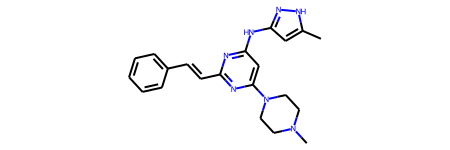

In [8]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw


def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

# Test in a kinase inhibitor
mol = Chem.MolFromSmiles("CN1CCN(CC1)C1=CC(NC2=NNC(C)=C2)=NC(\\C=C\\C2=CC=CC=C2)=N1")
# Default
mol

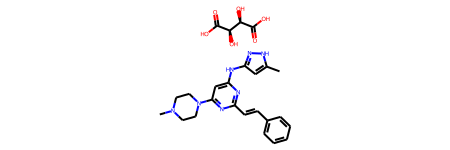

In [9]:
# Test in a kinase inhibitor
mol = Chem.MolFromSmiles("O[C@H]([C@@H](O)C(O)=O)C(O)=O.CN1CCN(CC1)C1=NC(\\C=C\\C2=CC=CC=C2)=NC(NC2=NNC(C)=C2)=C1")
# Default
mol

___________

## Create drug SMILES dict

In [10]:
drug_dict = dict(zip(adata_cpi.obs.condition, adata_cpi.obs.SMILES))

The dict has 188 different entries

In [11]:
len(drug_dict)

188

Checking that the `'ENMD-2076'` entry does not include the adid:

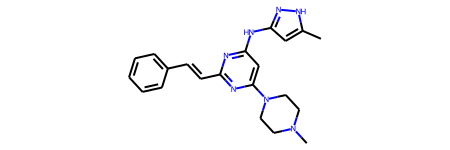

In [12]:
Chem.MolFromSmiles(drug_dict['ENMD-2076'])

This is a good wat to check the unique `(drug, smiles)` combinations that exist in the `adata_cpi`

In [13]:
# np.unique([f'{condition}_{smiles}' for condition, smiles in list(zip(adata_cpi.obs.condition, adata_cpi.obs.SMILES))])

## Rename weird drug `(+)-JQ1`
This had a different name in the old Sciplex dataset, where it was called `JQ1`. We rename it for consistency.

In [14]:
adata_cpa.obs["condition"] = adata_cpa.obs["condition"].cat.rename_categories({"(+)-JQ1": "JQ1"})

## Add SMILES to `adata_cpa`

In [15]:
adata_cpa.obs['SMILES'] = adata_cpa.obs.condition.map(drug_dict)

In [16]:
adata_cpa[adata_cpa.obs["condition"] == "JQ1"].obs["SMILES"].unique()

['CC1=NN=C2[C@H](CC(=O)OC(C)(C)C)N=C(C3=C(SC(C)...]
Categories (1, object): ['CC1=NN=C2[C@H](CC(=O)OC(C)(C)C)N=C(C3=C(SC(C)...]

## Check that SMILES match `obs.condition` data

Print some stats on the `condition` columns

In [17]:
print(f'We have {len(list(adata_cpa.obs.condition.value_counts().index))} drug names in adata_cpa: \n\n\t{list(adata_cpa.obs.condition.value_counts().index)}\n\n')
print(f'We have {len(list(adata_cpi.obs.condition.value_counts().index))} drug names in adata_cpi: \n\n\t{list(adata_cpi.obs.condition.value_counts().index)}')

We have 188 drug names in adata_cpa: 

	['control', 'ENMD-2076', 'PD98059', 'Tranylcypromine', 'WP1066', 'RG108', 'Tubastatin', 'Curcumin', 'GSK-LSD1', 'SRT2104', 'Busulfan', 'Baricitinib', 'Tacedinaline', 'Capecitabine', 'Tofacitinib', 'Tazemetostat', 'Entacapone', 'BRD4770', 'WHI-P154', 'Mesna', 'Cerdulatinib', 'CEP-33779', 'Anacardic', 'GSK', 'Daphnetin', 'Altretamine', 'PJ34', 'Filgotinib', 'Ofloxacin', 'Triamcinolone', 'UNC0631', 'Clevudine', 'Sirtinol', 'AICAR', 'Valproic', 'AG-490', 'NVP-BSK805', 'MK-0752', 'IOX2', 'Sodium', 'Zileuton', 'Fasudil', 'Meprednisone', 'S3I-201', 'Ramelteon', 'Aminoglutethimide', 'JNJ-26854165', 'Fulvestrant', 'Andarine', 'S-Ruxolitinib', 'MC1568', 'Costunolide', 'INO-1001', 'AG-14361', 'A-366', 'Fluorouracil', 'Streptozotocin', 'Entinostat', 'Selisistat', 'UNC1999', 'Motesanib', 'TGX-221', 'Ki8751', 'Resminostat', 'Quercetin', 'Maraviroc', 'Ki16425', 'PD173074', 'UNC0379', 'BMS-265246', 'EED226', 'Amisulpride', 'Tie2', 'Thiotepa', 'Roscovitine', 'AC4

Check that assigned SMILES match the condition,  
it should be just one smiles string per condition

In [18]:
(adata_cpa.obs.condition=='nan').sum()

0

### Check for nans

In [19]:
(adata_cpa.obs.condition=='nan').sum()

0

### Take care of `control` SMILES

In [20]:
counts = adata_cpa[adata_cpa.obs.condition=='control'].obs.SMILES.value_counts()
list(counts.index[counts>0])

['']

Add DMSO SMILES:`CS(C)=O`

In [21]:
adata_cpa.obs["SMILES"] = adata_cpa.obs["SMILES"].astype("category").cat.rename_categories({"": "CS(C)=O"})

In [22]:
adata_cpa.obs.loc[adata_cpa.obs.condition=='control', 'SMILES'].value_counts()

CS(C)=O                                                                                                                13004
Cl.Cl.CN1C=C(CNCC2CCN(CC2)C2=NC=C(C=N2)C(=O)NO)C2=CC=CC=C12 |c:16,18,27,t:2,14,25,29|                                      0
CCC1=CC=CC(CC)=C1NC(=O)N1CC2=C(C1)C(NC(=O)C1=CC=C(C=C1)N1CCN(C)CC1)=NN2 |c:4,8,16,26,28,38,t:2,24|                         0
CN(C)CC(=O)NC1=CC2=C(NC(=O)C3=C2C=CC=C3)C=C1 |c:14,17,19,22,t:7,9|                                                         0
CC1=C(CCNCC2=CC=C(\C=C\C(=O)NO)C=C2)C2=C(N1)C=CC=C2 |c:1,17,20,24,26,t:7,9|                                                0
                                                                                                                       ...  
CN1C=C(C2=CC=CC=C12)C1=C(C(=O)NC1=O)C1=CN(C2CCN(CC3=NC=CC=C3)CC2)C2=CC=CC=C12 |c:2,6,30,32,40,t:4,8,12,20,28,38,42|        0
CC1CCCC2OC2CC(OC(=O)CC(O)C(C)(C)C(=O)C(C)C1O)\C(C)=C\C3=CSC(=N3)C                                                          0


### Check double assigned condition

In [23]:
for pert, df in adata_cpa.obs.groupby('condition'):
    n_smiles = (df.SMILES.value_counts()!=0).sum()
    print(f"{pert}: {n_smiles}") if n_smiles > 1 else None

Check that condition align with SMILES

If everything is correct there should be no output

In [23]:
for pert, df in adata_cpa.obs.groupby('condition'):
    n_smiles = (df.SMILES.value_counts()!=0).sum()
    print(f"{pert}: {n_smiles}") if n_smiles > 1 else None

## Make SMILES canonical

In [24]:
print(f'rdkit version: {rdkit.__version__}\n')

adata_cpa.obs.SMILES = adata_cpa.obs.SMILES.apply(Chem.CanonSmiles)

rdkit version: 2021.03.2



## Rename weird drug `(+)-JQ1`
This had a different name in the old Sciplex dataset, where it was called `JQ1`. We rename it for consistency.

In [25]:
adata_cpa.obs["condition"] = adata_cpa.obs["condition"].cat.rename_categories({"(+)-JQ1": "JQ1"})

## Create subset `adata_cpa_subset` from `adata_cpa`

In [26]:
adatas = []

for drug in np.unique(adata_cpa.obs.condition): 
    tmp = adata_cpa[adata_cpa.obs.condition == drug].copy()
    tmp = sc.pp.subsample(tmp, n_obs=50, copy=True)
    adatas.append(tmp)

adata_cpa_subset = adatas[0].concatenate(adatas[1:])
adata_cpa_subset.uns = adata_cpa.uns.copy()

adata_cpa_subset

AnnData object with n_obs × n_vars = 9400 × 977
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle', 'batch', 'n_counts', 'dose_val', 'condition', 'drug_dose_name', 'cov_drug_dose_name', 'cov_drug', 'control', 'split', 'split_all', 'ct_dose', 'split1', 'split2', 'split3', 'split4', 'split5', 'split6', 'split7', 'split8', 'split9', 'split10', 'split11', 'split12', 'split13', 'split14', 'split15', 'split16', 'split17', 'split18', 'split19', 'split20', 'split21', 'split22', 'split23', 'split24', 'split25', 'split26', 'split27', 'split28', 'SMILES'
    var: 'id', 'gene_id', 'in_lincs', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1'
    uns: 'hvg', 'rank_genes_groups_cov', 'splits'

## Safe both adata objects

In [27]:
adata_cpa.write(adata_out)
adata_cpa_subset.write(adata_out_subset)

... storing 'dose_character' as categorical
... storing 'pathway' as categorical
... storing 'pathway_level_1' as categorical
... storing 'pathway_level_2' as categorical
... storing 'product_dose' as categorical
... storing 'product_name' as categorical
... storing 'target' as categorical
... storing 'condition' as categorical
... storing 'drug_dose_name' as categorical
... storing 'cov_drug_dose_name' as categorical
... storing 'cov_drug' as categorical
... storing 'split' as categorical
... storing 'split_all' as categorical
... storing 'ct_dose' as categorical
... storing 'split1' as categorical
... storing 'split2' as categorical
... storing 'split3' as categorical
... storing 'split4' as categorical
... storing 'split5' as categorical
... storing 'split6' as categorical
... storing 'split7' as categorical
... storing 'split8' as categorical
... storing 'split9' as categorical
... storing 'split10' as categorical
... storing 'split11' as categorical
... storing 'split12' as catego

### Loading the result for `adata_out`

In [28]:
adata = sc.read(adata_out_subset)
adata.obs.dose.value_counts()

10.0       2497
100.0      2453
1000.0     2362
10000.0    2038
0.0          50
Name: dose, dtype: int64

In [29]:
adata

AnnData object with n_obs × n_vars = 9400 × 977
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle', 'batch', 'n_counts', 'dose_val', 'condition', 'drug_dose_name', 'cov_drug_dose_name', 'cov_drug', 'control', 'split', 'split_all', 'ct_dose', 'split1', 'split2', 'split3', 'split4', 'split5', 'split6', 'split7', 'split8', 'split9', 'split10', 'split11', 'split12', 'split13', 'split14', 'split15', 'split16', 'split17', 'split18', 'split19', 'split20', 'split21', 'split22', 'split23', 'split24', 'split25', 'split26', 'split27', 'split28', 'SMILES'
    var: 'id', 'gene_id', 'in_lincs', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1'
    uns: 'hvg', 'rank_genes_groups_cov', 'splits'

In [30]:
adata_out

PosixPath('/storage/groups/ml01/projects/2021_chemicalCPA_leon.hetzel/datasets/trapnell_cpa_lincs_genes.h5ad')